In [1]:
!pip install augini

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.4/362.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from augini import Augini
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import json

# Set up Augini
api_key = "sk-XXXX"  # Replace with your actual API key
augini = Augini(api_key=api_key, use_openrouter=True, model='openai/gpt-4o-mini-2024-07-18')

In [3]:
# Create a sample customer dataset
np.random.seed(42)
n_customers = 100

data = {
    'CustomerID': [f'C{i:04d}' for i in range(1, n_customers + 1)],
    'Age': np.random.randint(18, 80, n_customers),
    'Tenure': np.random.randint(0, 10, n_customers),
    'MonthlyCharges': np.random.uniform(20, 200, n_customers).round(2),
    'TotalCharges': np.random.uniform(100, 5000, n_customers).round(2),
    'Contract': np.random.choice(['Month-to-month', 'One year', 'Two year'], n_customers),
    'PaymentMethod': np.random.choice(['Electronic check', 'Mailed check', 'Bank transfer', 'Credit card'], n_customers),
    'Churn': np.random.choice([0, 1], n_customers, p=[0.7, 0.3])  # 30% churn rate
}

df = pd.DataFrame(data)

print("Original Dataset:")
display(df.head())

Original Dataset:


,CustomerID,Age,Tenure,MonthlyCharges,TotalCharges,Contract,PaymentMethod,Churn
0,C0001,56,9,31.68,313.66,One year,Electronic check,0
1,C0002,69,3,65.70,4973.30,One year,Bank transfer,0
2,C0003,46,7,64.44,2402.73,Month-to-month,Credit card,0
3,C0004,32,6,145.33,1469.85,Two year,Electronic check,0
4,C0005,60,8,148.21,4429.12,Month-to-month,Bank transfer,1


# 1. Data Augmentation: Add synthetic features using Augini

In [4]:
augment_prompt = """
Based on the customer's age, tenure, monthly charges, total charges, contract type, and payment method, suggest:
1. A likely reason for churn (if applicable)
2. A personalized retention offer
3. The customer's estimated lifetime value (in dollars)

Respond with a JSON object with keys 'ChurnReason', 'RetentionOffer', and 'EstimatedLTV'.
"""

augmented_df = augini.augment_columns(df, ['ChurnReason', 'RetentionOffer', 'EstimatedLTV'], custom_prompt=augment_prompt)

print("\nAugmented Dataset:")
display(augmented_df.head())


Augmented Dataset:


,CustomerID,Age,Tenure,MonthlyCharges,TotalCharges,Contract,PaymentMethod,Churn,ChurnReason,RetentionOffer,EstimatedLTV
0,C0001,56,9,31.68,313.66,One year,Electronic check,0,Customer is satisfied with current service and...,Offer a loyalty discount of 15% on monthly cha...,1010.88
1,C0002,69,3,65.70,4973.30,One year,Bank transfer,0,Customer may feel their needs are not being fu...,Offer a 20% discount on monthly charges for th...,19788.00
2,C0003,46,7,64.44,2402.73,Month-to-month,Credit card,0,"The customer is on a month-to-month contract, ...",Offer a discounted rate of $54.44 per month fo...,4313.48
3,C0004,32,6,145.33,1469.85,Two year,Electronic check,0,N/A - Customer is currently retained.,Offer a 10% discount on monthly charges for th...,3489.84
4,C0005,60,8,148.21,4429.12,Month-to-month,Bank transfer,1,Potential dissatisfaction with service value d...,Offer a discounted rate of $120 per month for ...,5313.36


In [5]:
# After augmenting the dataset
print("\nExample Augmented Data:")
for i in range(3):
    customer = augmented_df.iloc[i]
    print(f"\nCustomer ID: {customer['CustomerID']}")
    print(f"Age: {customer['Age']}, Tenure: {customer['Tenure']}, Monthly Charges: ${customer['MonthlyCharges']:.2f}")
    print(f"Contract: {customer['Contract']}, Churn: {'Yes' if customer['Churn'] else 'No'}")
    print(f"Churn Reason: {customer['ChurnReason']}")
    print(f"Retention Offer: {customer['RetentionOffer']}")
    print(f"Estimated LTV: ${customer['EstimatedLTV']:.2f}")


Example Augmented Data:

Customer ID: C0001
Age: 56, Tenure: 9, Monthly Charges: $31.68
Contract: One year, Churn: No
Churn Reason: Customer is satisfied with current service and has a stable payment method, indicating low risk of churn.
Retention Offer: Offer a loyalty discount of 15% on monthly charges for the next 6 months.
Estimated LTV: $1010.88

Customer ID: C0002
Age: 69, Tenure: 3, Monthly Charges: $65.70
Contract: One year, Churn: No
Churn Reason: Customer may feel their needs are not being fully met or they are evaluating options due to age-related considerations.
Retention Offer: Offer a 20% discount on monthly charges for the next 6 months and a complimentary upgrade to a premium service.
Estimated LTV: $19788.00

Customer ID: C0003
Age: 46, Tenure: 7, Monthly Charges: $64.44
Contract: Month-to-month, Churn: No
Churn Reason: The customer is on a month-to-month contract, which may indicate they are considering alternatives or are less committed to the service.
Retention Off

Key Observations:

- The **augini** generates personalized retention offers based on each customer's specific situation, considering factors like age, contract type, and perceived churn risk.
- Estimated LTV varies significantly, highlighting the importance of tailored retention strategies for high-value customers.
- The **augini** identifies potential churn reasons even for non-churned customers, allowing for proactive retention efforts.
- The retention offers are designed to address the specific concerns or risk factors identified for each customer.

# 2. Data Analysis and Visualization

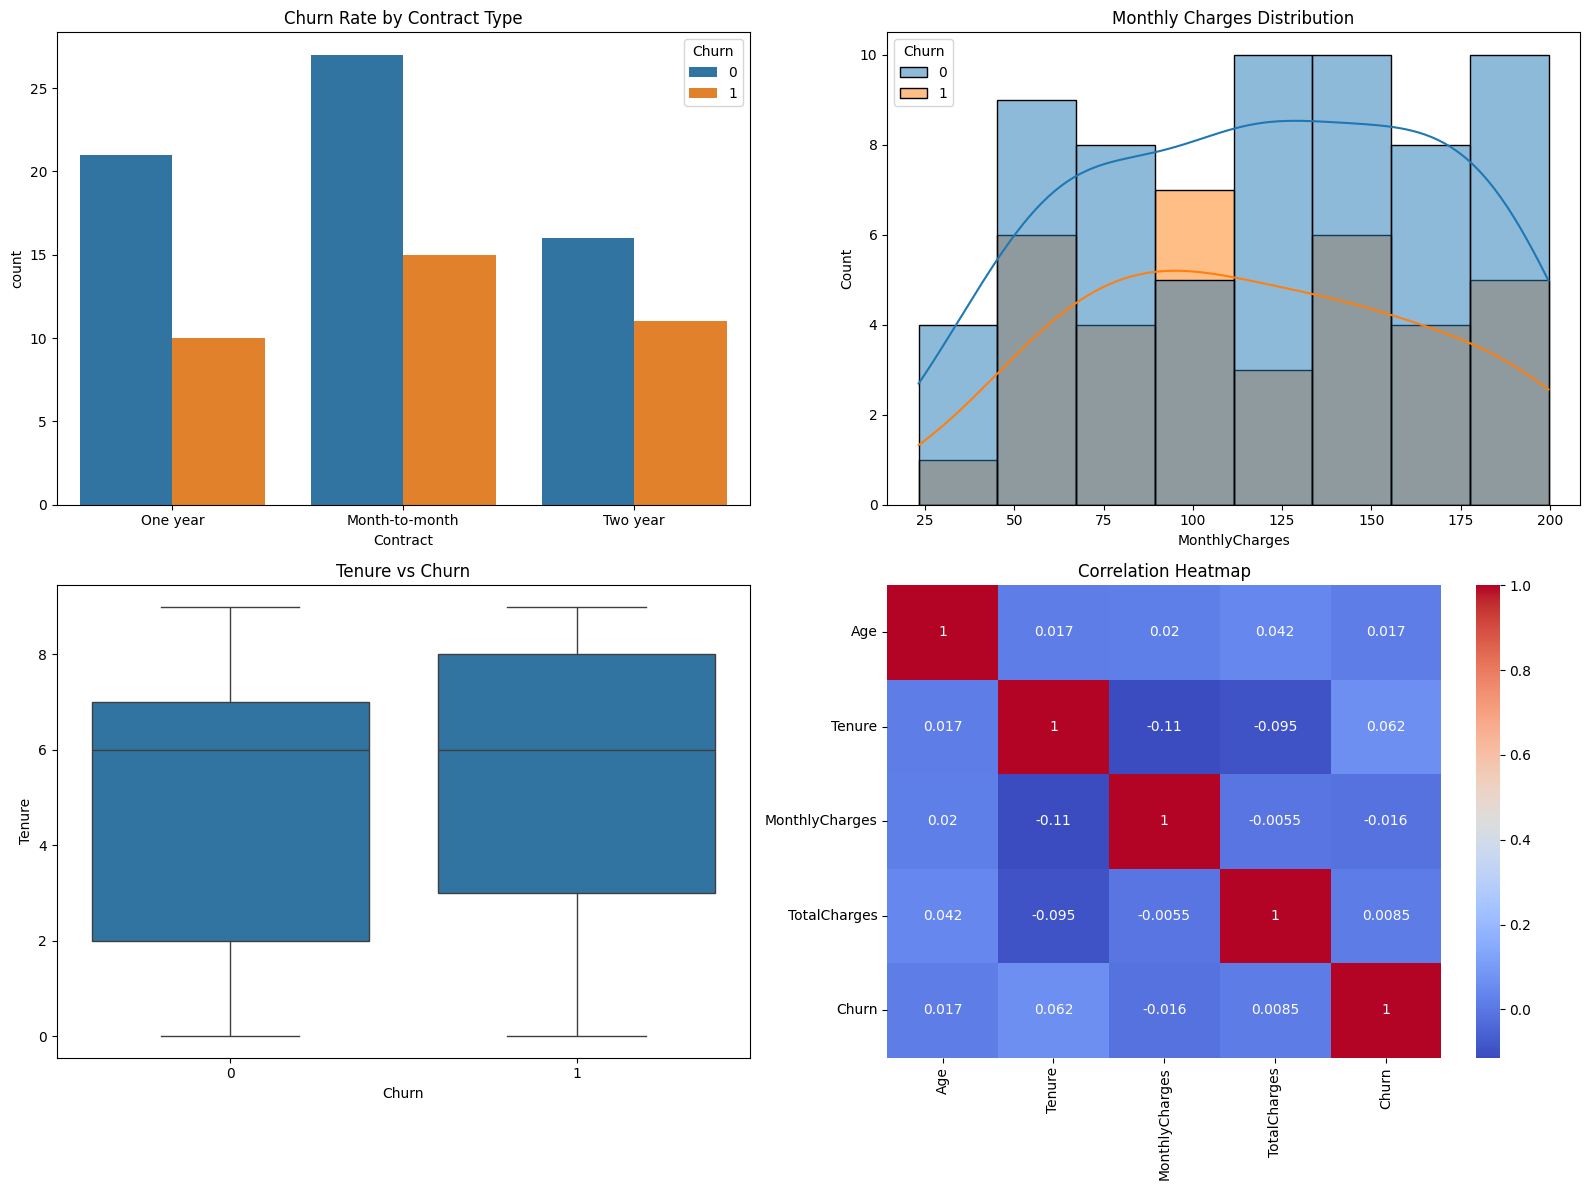

In [6]:
plt.figure(figsize=(16, 12))

# Churn rate by contract type
plt.subplot(2, 2, 1)
sns.countplot(data=df, x='Contract', hue='Churn')
plt.title('Churn Rate by Contract Type')

# Monthly charges distribution for churned vs non-churned customers
plt.subplot(2, 2, 2)
sns.histplot(data=df, x='MonthlyCharges', hue='Churn', kde=True)
plt.title('Monthly Charges Distribution')

# Tenure vs Churn
plt.subplot(2, 2, 3)
sns.boxplot(data=df, x='Churn', y='Tenure')
plt.title('Tenure vs Churn')

# Correlation heatmap
plt.subplot(2, 2, 4)
corr_matrix = df[['Age', 'Tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')

plt.tight_layout()
plt.show()



# 3. Churn Prediction Model


Churn Prediction Model Performance:
              precision    recall  f1-score   support

           0       0.60      0.69      0.64        13
           1       0.20      0.14      0.17         7

    accuracy                           0.50        20
   macro avg       0.40      0.42      0.40        20
weighted avg       0.46      0.50      0.48        20



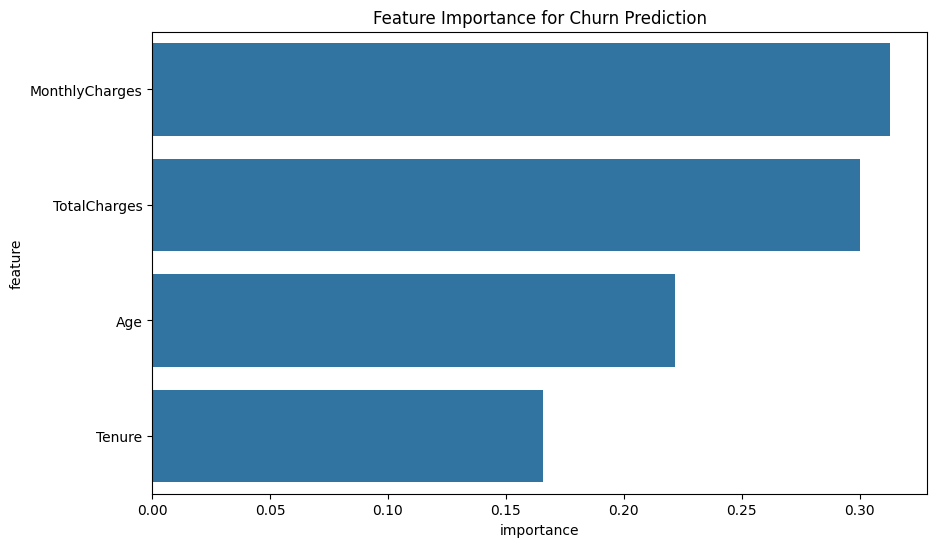

In [7]:
features = ['Age', 'Tenure', 'MonthlyCharges', 'TotalCharges']
X = df[features]
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("\nChurn Prediction Model Performance:")
print(classification_report(y_test, y_pred))

# 4. Feature Importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance for Churn Prediction')
plt.show()



# 5. Insights Generation using Augini

In [8]:
insights_prompt = """
Based on the customer churn analysis, provide three key insights about customer behavior, churn patterns, and potential retention strategies.
Consider factors such as contract types, payment methods, tenure, and charges.

Respond with a JSON object with keys 'Insight1', 'Insight2', and 'Insight3'.
"""

# Use augment_single with the entire DataFrame
insights = augini.augment_single(augmented_df.head(4), 'Insights', custom_prompt=insights_prompt)

In [9]:
insights.head()

,CustomerID,Age,Tenure,MonthlyCharges,TotalCharges,Contract,PaymentMethod,Churn,ChurnReason,RetentionOffer,EstimatedLTV,Insights
0,C0001,56,9,31.68,313.66,One year,Electronic check,0,Customer is satisfied with current service and...,Offer a loyalty discount of 15% on monthly cha...,1010.88,{'Insight1': 'Customers with longer tenure (ov...
1,C0002,69,3,65.70,4973.30,One year,Bank transfer,0,Customer may feel their needs are not being fu...,Offer a 20% discount on monthly charges for th...,19788.00,{'Insight1': 'Customers with longer tenures ar...
2,C0003,46,7,64.44,2402.73,Month-to-month,Credit card,0,"The customer is on a month-to-month contract, ...",Offer a discounted rate of $54.44 per month fo...,4313.48,{'Insight1': 'Customers on month-to-month cont...
3,C0004,32,6,145.33,1469.85,Two year,Electronic check,0,N/A - Customer is currently retained.,Offer a 10% discount on monthly charges for th...,3489.84,"{'Insight1': 'Customers with longer tenure, su..."


In [10]:
print("Insights from the first 3 rows:")
for i in range(3):
    insight = insights['Insights'].iloc[i]
    print(f"\nRow {i + 1}:")
    if isinstance(insight, dict):
        for key, value in insight.items():
            print(f"{key}: {value}")
    else:
        print("Unexpected data type. Raw insight:")
        print(insight)
    print("-" * 50)  # Separator between rows

Insights from the first 3 rows:

Row 1:
Insight1: Customers with longer tenure (over 6 months) tend to have lower churn rates. This indicates that tenure is a strong predictor of customer satisfaction and retention, as seen with Customer C0001 who has a tenure of 9 months and is satisfied with the service.
Insight2: Payment methods play a significant role in customer loyalty. Customers using electronic checks, like Customer C0001, show a preference for stable and automated payments, which reduces churn risk compared to those using credit cards or manual payment methods.
Insight3: Implementing loyalty offers can effectively retain customers. Offering a 15% discount, as suggested for Customer C0001, could reinforce customer loyalty and enhance lifetime value, especially for those on one-year contracts who are satisfied with their service.
--------------------------------------------------

Row 2:
Insight1: Customers with longer tenures are less likely to churn, as evidenced by the data s

# 6. Retention Strategy Recommendations

In [11]:
strategy_prompt = """
Based on the churn analysis and generated insights, provide three strategic recommendations to reduce customer churn and improve retention.
Consider personalized offers, pricing strategies, contract adjustments, and customer engagement initiatives.

Respond with a JSON object with keys 'Strategy1', 'Strategy2', 'Strategy3'.
"""

strategies = augini.augment_single(augmented_df.head(4), 'Strategies', custom_prompt=strategy_prompt)

In [12]:
# Assuming your DataFrame is named 'insights'
print("Strategies from the first 3 rows:")
for i in range(3):
    insight = strategies['Strategies'].iloc[i]
    print(f"\nRow {i + 1}:")
    if isinstance(insight, dict):
        for key, value in insight.items():
            print(f"{key}: {value}")
    else:
        print("Unexpected data type. Raw insight:")
        print(insight)
    print("-" * 50)  # Separator between rows

Strategies from the first 3 rows:

Row 1:
Strategy1: {'Description': 'Implement a personalized loyalty discount program for long-term customers.', 'Details': 'Offer a 15% discount on monthly charges for loyal customers like those with a tenure of 9 years or more. This incentivizes retention and rewards customer loyalty.'}
Strategy2: {'Description': 'Revise pricing strategies to include tiered pricing based on usage and customer needs.', 'Details': 'Introduce flexible pricing plans tailored to different customer segments, allowing customers to choose plans that best fit their usage patterns, which can lead to increased satisfaction and reduced churn.'}
Strategy3: {'Description': 'Enhance customer engagement initiatives to foster stronger relationships.', 'Details': 'Launch regular check-ins and feedback surveys with customers to address any concerns proactively and offer personalized solutions, thus increasing customer satisfaction and reducing churn risk.'}
----------------------------

# Summary of Retention Strategies

## Strategy 1: Personalized Offers and Loyalty Programs

- **Long-term Customers**: Implement a personalized loyalty discount program, offering up to 15% off monthly charges for customers with 9+ years tenure.
- **Age-based Targeting**: Tailor offers based on age demographics, particularly for senior customers.
- **Contract Commitment**: Encourage month-to-month customers to switch to longer-term plans with incentives like discounted rates (e.g., $54.44/month for 6 months on a 12-month contract).

## Strategy 2: Flexible and Tiered Pricing

- **Usage-based Plans**: Introduce flexible pricing options that align with different usage patterns and customer needs.
- **Senior-friendly Options**: Develop tiered pricing that caters specifically to senior citizens' budgets and service requirements.
- **Competitive Alignment**: Analyze the market to ensure prices reflect perceived value and introduce loyalty rewards for long-term customers.

## Strategy 3: Enhanced Customer Engagement

- **Proactive Communication**: Establish regular check-ins with customers to address concerns and offer personalized solutions.
- **Feedback Mechanism**: Implement quarterly customer satisfaction surveys to gather insights and preemptively address issues.
- **Relationship Building**: Foster stronger connections through ongoing engagement initiatives and responsive customer service.

These strategies focus on personalizing offers, creating flexible pricing structures, and improving customer engagement to reduce churn and enhance overall customer satisfaction.